In [1]:
#!pip install timm==0.6.2.dev0 --user


In [19]:
from fastai.vision.all import *
from fastcore.parallel import *


In [2]:
Path.BASE_PATH = path = Path.home()/'paddy'
trn_path = path/'train_images'

In [3]:
path.ls()

(#4) [Path('train_images'),Path('train.csv'),Path('sample_submission.csv'),Path('test_images')]

In [4]:
trn_path.ls()

(#10) [Path('train_images/bacterial_leaf_streak'),Path('train_images/hispa'),Path('train_images/normal'),Path('train_images/blast'),Path('train_images/dead_heart'),Path('train_images/bacterial_leaf_blight'),Path('train_images/tungro'),Path('train_images/bacterial_panicle_blight'),Path('train_images/brown_spot'),Path('train_images/downy_mildew')]

In [5]:
blb = trn_path/'bacterial_leaf_blight'
blb.ls()

(#479) [Path('train_images/bacterial_leaf_blight/100982.jpg'),Path('train_images/bacterial_leaf_blight/109588.jpg'),Path('train_images/bacterial_leaf_blight/101638.jpg'),Path('train_images/bacterial_leaf_blight/100234.jpg'),Path('train_images/bacterial_leaf_blight/101647.jpg'),Path('train_images/bacterial_leaf_blight/104657.jpg'),Path('train_images/bacterial_leaf_blight/103357.jpg'),Path('train_images/bacterial_leaf_blight/109673.jpg'),Path('train_images/bacterial_leaf_blight/104106.jpg'),Path('train_images/bacterial_leaf_blight/101659.jpg')...]

In [6]:
df = pd.read_csv(path/'train.csv')

In [9]:
df

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45
...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55
10403,107811.jpg,tungro,Zonal,55
10404,108547.jpg,tungro,Zonal,55
10405,110245.jpg,tungro,Zonal,55


In [7]:
files = get_image_files(trn_path)
files

(#10407) [Path('train_images/bacterial_leaf_streak/100081.jpg'),Path('train_images/bacterial_leaf_streak/104135.jpg'),Path('train_images/bacterial_leaf_streak/108249.jpg'),Path('train_images/bacterial_leaf_streak/100235.jpg'),Path('train_images/bacterial_leaf_streak/105265.jpg'),Path('train_images/bacterial_leaf_streak/109925.jpg'),Path('train_images/bacterial_leaf_streak/106054.jpg'),Path('train_images/bacterial_leaf_streak/103307.jpg'),Path('train_images/bacterial_leaf_streak/106974.jpg'),Path('train_images/bacterial_leaf_streak/101151.jpg')...]

In [8]:
img = PILImage.create(files[0])

In [9]:
img.size

(480, 640)

The image file is loaded from the disk one at a time. We are try to parallelize the process in the CPU.

In [10]:
%time sizes = [PILImage.create(i).size for i in files]

CPU times: user 29.6 s, sys: 550 ms, total: 30.1 s
Wall time: 30.2 s


In [14]:
#parallel??

In [11]:
def f(i): return PILImage.create(i).size

In [12]:
%time sizes = parallel(f, files, n_workers=4)

CPU times: user 4.21 s, sys: 850 ms, total: 5.06 s
Wall time: 30.8 s


We are creating  the dataloders in the fastai dataloders format. It takes the input from the file, devides the data in 80:20 and resizes to 224*240

In [13]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, item_tfms=Resize(224))

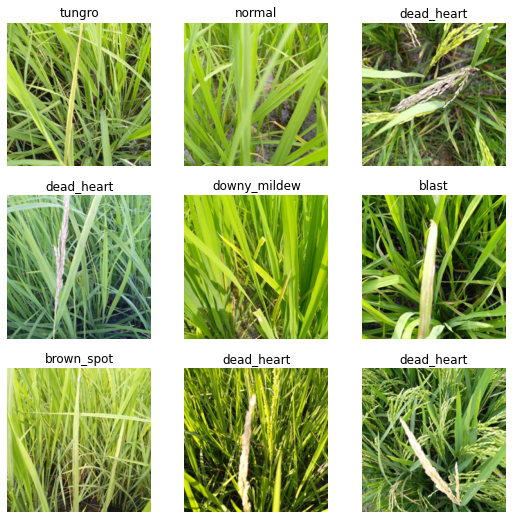

In [14]:
dls.show_batch()

Create learner object of type *vision* to *fine tune* **resnet34** and print error rate.

In [19]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0012022644514217973)

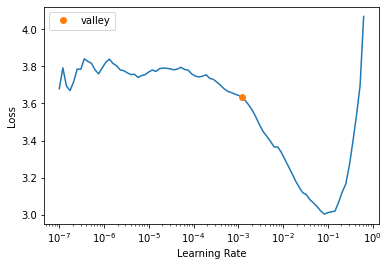

In [20]:
learn.lr_find()

In [21]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.917313,1.048451,0.337338,01:22


epoch,train_loss,valid_loss,error_rate,time
0,0.730405,0.434921,0.131667,01:46


In [22]:
learn = vision_learner(dls, resnet34, metrics=error_rate).to_fp16()
learn.fine_tune(2)


epoch,train_loss,valid_loss,error_rate,time
0,1.966565,1.052052,0.332532,01:25


epoch,train_loss,valid_loss,error_rate,time
0,0.786885,0.419544,0.133109,01:49
1,0.330593,0.256624,0.075444,01:49


In [22]:
test_files = get_image_files(path/'test_images')
test_files

(#3469) [Path('test_images/201927.jpg'),Path('test_images/201329.jpg'),Path('test_images/201728.jpg'),Path('test_images/200716.jpg'),Path('test_images/201301.jpg'),Path('test_images/202173.jpg'),Path('test_images/200450.jpg'),Path('test_images/201410.jpg'),Path('test_images/202244.jpg'),Path('test_images/201612.jpg')...]

In [23]:
test_dls = dls.test_dl(test_files)

In [24]:
learn.get_preds(dl =test_dls)

(TensorBase([[9.0080e-05, 9.9964e-01, 4.1879e-07,  ..., 4.5833e-06, 1.5125e-06,
          2.2372e-07],
         [7.2256e-05, 5.2452e-05, 6.0236e-07,  ..., 2.0655e-07, 6.2139e-08,
          1.1474e-07],
         [4.8265e-07, 4.7247e-06, 3.6718e-07,  ..., 2.1647e-06, 1.9626e-10,
          2.9823e-07],
         ...,
         [2.0286e-11, 6.8215e-12, 1.0881e-10,  ..., 5.6459e-10, 1.6203e-12,
          5.4410e-09],
         [7.8572e-07, 1.3342e-05, 8.8795e-07,  ..., 1.7193e-07, 1.9626e-10,
          3.3405e-06],
         [1.3109e-05, 9.6426e-09, 5.1799e-07,  ..., 1.9902e-08, 4.4227e-10,
          2.6480e-05]]),
 None)

In [25]:
pred = learn.get_preds(dl =test_dls,with_decoded=True)

In [27]:
prob, _, idxs = pred

In [28]:
idxs = pd.Series(idxs.numpy(), name = 'idxs')

In [29]:
list(dls.vocab)

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [30]:
mapping = {k:v for k,v in enumerate(dls.vocab)}


In [31]:
results = idxs.map(mapping)

In [32]:
results.head

<bound method NDFrame.head of 0       bacterial_leaf_streak
1                  brown_spot
2                       blast
3                  brown_spot
4                       hispa
                ...          
3464                   tungro
3465                   tungro
3466             downy_mildew
3467                    blast
3468                    blast
Name: idxs, Length: 3469, dtype: object>

In [33]:
ss = pd.read_csv(path/'sample_submission.csv')

In [34]:
ss.head

<bound method NDFrame.head of         image_id  label
0     200001.jpg    NaN
1     200002.jpg    NaN
2     200003.jpg    NaN
3     200004.jpg    NaN
4     200005.jpg    NaN
...          ...    ...
3464  203465.jpg    NaN
3465  203466.jpg    NaN
3466  203467.jpg    NaN
3467  203468.jpg    NaN
3468  203469.jpg    NaN

[3469 rows x 2 columns]>

In [35]:
ss['label']=results

In [36]:
ss.columns = ["Image_id", "label"]

In [37]:
ss.to_csv('submit.csv')

In [38]:
!head submit.csv

,Image_id,label
0,200001.jpg,bacterial_leaf_streak
1,200002.jpg,brown_spot
2,200003.jpg,blast
3,200004.jpg,brown_spot
4,200005.jpg,hispa
5,200006.jpg,normal
6,200007.jpg,dead_heart
7,200008.jpg,tungro
8,200009.jpg,blast


In [39]:
ss.to_csv('submit.csv', index = False)

using **timm**

In [15]:
import timm

In [16]:
timm.list_models('convnext*')

['convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano_hnf',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_hnfd',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [17]:
learn = vision_learner(dls, 'convnext_small_in22k',metrics=error_rate).to_fp16()

In [20]:

learn.fine_tune(3)


epoch,train_loss,valid_loss,error_rate,time
0,0.335451,0.345599,0.109563,10:04


epoch,train_loss,valid_loss,error_rate,time
0,0.273232,0.236130,0.069678,11:34
1,0.211632,0.181376,0.055262,11:35
2,0.149533,0.162944,0.052859,11:35


In [46]:
nb_loc = Path()
nb_loc.ls()

(#8) [Path('requirements.txt'),Path('submit1.csv'),Path('set-up.sh'),Path('.git'),Path('readme.md'),Path('paddy.ipynb'),Path('submit.csv'),Path('.ipynb_checkpoints')]

In [49]:
nb_loc.ls(file_exts='.pkl')

(#0) []

In [48]:
learn.export()

In [42]:
learn.export??

Signature:
learn.export(
    fname='export.pkl',
    pickle_module=<module 'pickle' from '/root/mambaforge/lib/python3.9/pickle.py'>,
    pickle_protocol=2,
)
Source:   
@patch
def export(self:Learner, fname='export.pkl', pickle_module=pickle, pickle_protocol=2):
    "Export the content of `self` without the items and the optimizer state for inference"
    if rank_distrib(): return # don't export if child proc
    self._end_cleanup()
    old_dbunch = self.dls
    self.dls = self.dls.new_empty()
    state = self.opt.state_dict() if self.opt is not None else None
    self.opt = None
    with warnings.catch_warnings():
        #To avoid the warning that come from PyTorch about model not being checked
        warnings.simplefilter("ignore")
        torch.save(self, self.path/fname, pickle_module=pickle_module, pickle_protocol=pickle_protocol)
    self.create_opt()
    if state is not None: self.opt.load_state_dict(state)
    self.dls = old_dbunch
File:      ~/mambaforge/lib/python3.9/site-